In [1]:
using Pkg
Pkg.activate(joinpath(@__DIR__, ".."))
#Pkg.add(PackageSpec(url="https://git.ligo.org/will-farr/pisnmassfunctions.jl.git"))
#Pkg.resolve()
Pkg.instantiate()

  Activating environment at `~/Projects/GW/PISN-Cali/O3a-PISN/Project.toml`


In [2]:
using Cosmology
using HDF5
using LaTeXStrings
using Statistics
using StatsBase
using StatsPlots
using Unitful
using UnitfulAstro
#using O3aPISN
using PISNMassFunctions
using Plots
using Interpolations
using Turing
using LogExpFunctions
using JSON3
using PairPlots
using AdvancedHMC

default(fmt=png)

Let's load up the mock observations.  We get 2D arrays of posterior samples for $m_{1,\mathrm{detector}}$, $q$, and $d_L$, as well as the log of the prior weight applied to these variables; we also get 1D arrays of the true $m_{1,\mathrm{source}}$, $q$, and $z$.

In [138]:
alpha_true = 4.8
beta_true = 2.1
gamma_true = 0.2
kappa_true = 3.1
z_p_true = 1.9
MMin_true = 4.6
smooth_min_true = 0.15
smooth_max_true = 0.17
H0_true = 67.74
Om_true = 0.3075
w_true = -1.0

H0 = H0_true
Om = Om_true
w = w_true
mmin_true = MMin_true
smin = smooth_min_true
smax = smooth_max_true
zp_true = z_p_true
dH = 299.792/H0

4.4256273988780634

In [139]:

N = 1000
Nfullsamp = 120
Nsamp = 32
Ninterp = 1024
zmax = 25

a = 288356593172758950956953087364047537605

288356593172758950956953087364047537605

In [140]:
using Random
rng = Random.Random.MersenneTwister(a)

MersenneTwister(0xd8ef75b1de0af2710808c722832785c5)

In [141]:
function fsmooth(m, ml, mh, sl, sh)
    return cdf.(Normal(log(ml), sl), log(m)) * (1 - cdf.(Normal(log(mh), sh), log(m)))
end

fsmooth (generic function with 1 method)

In [142]:

function Ez(z, Om, Ol, w0, wm) 
    opz = 1.0 .+ z
    opz2 = opz .* opz
    opz3 = opz2 .* opz
    Ok = 1.0 - Om - Ol
    return (Om .* opz3 .^(1.0+wm) .+ Ol .* opz3 .^(1.0 + w0) .+ Ok .* opz2) .^0.5
end

function dC(zs, dH, Om, Ol, w0, wm)
    n = length(zs)
    igrd = [dH/Ez(zs[i], Om, Ol, w0, wm) for i in 1:n]
    dCs = cumtrapz(zs, igrd)

    return dCs
end
    
function dM_of_dC(dCs, dH, Om, Ol, w0, wm)
    n = length(dCs)
    Ok = 1.0 - Om - Ol

    if Ok < 0
    dMs = dH ./ (-Ok)^0.5 .* sin.(dCs .* (-Ok)^0.5 ./ dH)
    elseif Ok > 0
    dMs = dH ./ (Ok)^0.5 .* sinh.(dCs .* (Ok)^0.5 ./ dH)
    else
    dMs = dCs
    end

    return dMs
end

function dL_of_dM(dMs, zs)

    dLs = dMs.*(1 .+ zs)

    return dLs
end

function diff_comoving_volume(zs, H0, Om, Ol, w0, wm)
    dcs = dC(zs, 299.792/H0, Om, Ol, w0, wm)
    #return 299.792 ./ H0 .* (dM_of_dC(dcs, 299.792/H0, Om, Ol, w0, wm) .^ 2.0) ./ Ez(zs, Om, Ol, w0, wm)
    return 299.792 ./ H0 .* (dcs .^ 2.0) ./ Ez(zs, Om, Ol, w0, wm)

end

function dLs(zs, H0, Om, Ol, w0, wm)
    dH = 299.792/H0
    return dL_of_dM(dM_of_dC(dC(zs, dH, Om, Ol, w0, wm), dH, Om, Ol, w0, wm), zs)
end

dLs (generic function with 1 method)

In [143]:

function draw_z(zp, gamma = gamma_true, kappa = kappa_true, size=1, zmax=20, rng=rng)
    zs = expm1.(range(log(1), log(1+zmax), length=1024)) 
    diff_co_v = diff_comoving_volume(zs, H0, Om, 1-Om, -1, 0)
    pz_interp = (1 .+ zs).^gamma./(1 .+ ((1 .+ zs)./(1 + zp)).^kappa) .* diff_co_v./(1 .+ zs)
    pz_interp = -pz_interp ./ trapz(pz_interp, zs)
    cz = cumtrapz(zs, pz_interp)
    drawer_z = LinearInterpolation(cz, zs)
    return drawer_z(rand!(rng, zeros(size)))
end


draw_z (generic function with 6 methods)

In [144]:
z = expm1.(range(log(1), log(1+zmax), length=1024)) 
d = dLs(z, H0, Om, 1-Om, -1, 0) #[comoving_transverse_dist(cosmo, z[i]) for i in 1:1024] .* (1 .+ z) ./ 1000 ./ u"Mpc" # luminosity distance
d_of_z = LinearInterpolation(z, d)
z_of_d = LinearInterpolation(d, z)
print(" ")

The posterior samples show some structure in the $m_{1,\mathrm{detector}}$ vs $d_L$ plane:

In [145]:

d1 = d_of_z(1)

function sigma_d(d)
    return 3e-4*d*d
end
function sigma_m1(m1, d)
    return 0.01*m1*d/d1
end
function sigma_q(q, d)
    return 0.01*q*d/d1
end


sigma_q (generic function with 1 method)

In [146]:
function log_smooth(m, ml, sl, mh, sh)
    return log.(cdf.(Normal(log(ml), sl), log.(m))) .+ log.(1 .- cdf.(Normal(log(mh), sh), log.(m)))
end

log_smooth (generic function with 1 method)

In [147]:
function log_ddLdz(dl, z, dH, Om, Ol, w0, wm)
    n = length(dl)
    Ok = 1.0 - Om - Ol
    dc = dl ./ (1 .+ z)

    if Ok < 0
        fac = cos.(dc .* sqrt(-Ok) ./ dH)
    elseif Ok > 0
        fac = cosh.(dc .* sqrt(Ok) ./ dH)
    else
        fac = 1.0
    end

    H0 = 299.792/dH

    eofzs = Ez(z, Om, Ol, w0, wm)  #[EofZ(cosmo, z[i]) for i in 1:n]
    log_d = log.(dl ./ (1 .+ z) .+ (1 .+ z) .* dH ./ eofzs .* fac)

    return log_d
end

function log_dVdz(dl, z, dH, Om, Ol, w0, wm)
    n = length(dl)
    
    Ok = 1.0 - Om - Ol
    dc = dl ./ (1 .+ z)

    if Ok < 0
        fac = cos.(dc .* sqrt(-Ok) ./ dH)
    elseif Ok > 0
        fac = cosh.(dc .* sqrt(Ok) ./ dH)
    else
        fac = 1.0
    end
    
    log_4pi = log(4.0*pi)
    log_dH = log(dH)
    H0 = 299.792/dH

    eofzs = Ez(z, Om, Ol, w0, wm)
    log_dc = log.(dc)
    log_dV = log_dH .+ 2.0 .* log_dc .- log.(eofzs) .+ log.(fac)# .+ log_4pi

    return log_dV
end


log_dVdz (generic function with 1 method)

In [148]:

function wofz(z,w0,wz)
    return w0 .*10 .^(wz .*z)
end

function epsilon(z,w0,wz,alpha,mu0,muz)
    beta = alpha/(1+alpha^2)^0.5
    return -wofz(z,w0,wz).^2 ./2 .*log.(mu0.*10 .^(muz.*z)./2 ./cdf.(lognorm,beta .*wofz(z,w0,wz)))
end

function mrate(Z,z,w0,wz,alpha,mu0,muz)
    lognorm = LogNormal(epsilon(z,w0,wz,alpha,mu0,muz), wofz(z,w0,wz))
    #lognorma = LogNormal(epsilon(z,w0,wz,alpha,mu0,muz), wofz(z,w0,wz)/alpha)
    return 2/Z .*pdf.(lognorm,log(Z))# .*cdf.(lognorm,log(Z))
end

function dPdZ(Z,z, Z0, alpha,sigma)
    Zz = Z0*10^(alpha*z)
    mu = log(Zz) - sigma^2/2
    lognorm = LogNormal(mu, sigma)
    #return 1/Z/sigma/(2*pi)^0.5*exp(-(log(Z)-mu)^2/2/sigma^2)
    return pdf.(lognorm, Z)
end

function mbh_max(b1, b2, b3, Z)
    return b3 .*(log10.(Z)).^2 .+ b2 .*log10.(Z) .+ b1
end

mbh_max (generic function with 1 method)

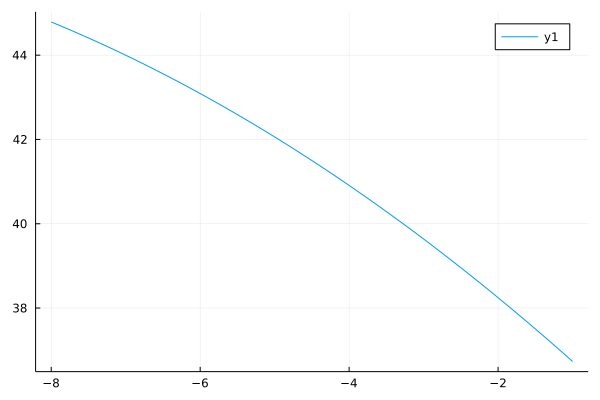

In [149]:
Z = range(-8,-1,length=1024)
b1,b2,b3 = 35.1, -3.9, -0.32
plot(Z, mbh_max(b1, b2, b3, exp.(Z)))

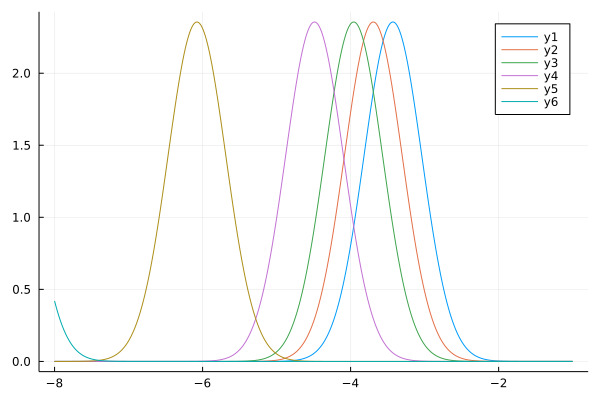

In [317]:
zmetal = expm1.(range(0, log(2), length=1024))
Z0, alphaz, sigmaz = 0.035, -0.23, 0.39

# plot(zmetal, [dPdZ(5e-3,zmetal[i],Z0,alpha,sigma) for i in 1:1024])
# plot!(zmetal, [dPdZ(6e-3,zmetal[i],Z0,alpha,sigma) for i in 1:1024])
# plot!(zmetal, [dPdZ(7e-3,zmetal[i],Z0,alpha,sigma) for i in 1:1024])
# plot!(zmetal, [dPdZ(1e-2,zmetal[i],Z0,alpha,sigma) for i in 1:1024])
# plot!(zmetal, [dPdZ(3e-2,zmetal[i],Z0,alpha,sigma) for i in 1:1024])
# plot!(zmetal, [dPdZ(5e-2,zmetal[i],Z0,alpha,sigma) for i in 1:1024])
# plot!(zmetal, [dPdZ(10^(-0.5),zmetal[i],Z0,alpha,sigma) for i in 1:1024])

plot(Z, [dPdZ(exp(Z[i]),0,Z0,alphaz,sigmaz)*exp(Z[i])*log(10) for i in 1:1024])
plot!(Z, [dPdZ(exp(Z[i]),0.5,Z0,alphaz,sigmaz)*exp(Z[i])*log(10) for i in 1:1024])
plot!(Z, [dPdZ(exp(Z[i]),1,Z0,alphaz,sigmaz)*exp(Z[i])*log(10) for i in 1:1024])
plot!(Z, [dPdZ(exp(Z[i]),2,Z0,alphaz,sigmaz)*exp(Z[i])*log(10) for i in 1:1024])
plot!(Z, [dPdZ(exp(Z[i]),5,Z0,alphaz,sigmaz)*exp(Z[i])*log(10) for i in 1:1024])
plot!(Z, [dPdZ(exp(Z[i]),10,Z0,alphaz,sigmaz)*exp(Z[i])*log(10) for i in 1:1024])




In [318]:
# function log_dNdm1dm2dz(m1s, m2s, dls, zs, mpeak, sipeak, fracpeak, alpha, beta, mmin, smin, mmax, smax, gamma, zp, kappah, kappal, dH, Om, Ol, w0, wm)
    
#     n = length(m1s)
#     log_dH = log(dH)
#     H0 = 299.792/dH

#     log_dV = log_dVdz(dls, zs, dH, Om, Ol, w0, wm)
#     #log_dV = log.(diff_comoving_volume(zs, H0, Om, Ol, w0, wm))
#     log_s1 = log_smooth(m1s, mmin, smin, mmax, smax)
#     log_s2 = log_smooth(m2s, mmin, smin, mmax, smax)

#     log_dN = log.((1-fracpeak).*m1s.^(-alpha) .* exp.(((gamma-1) .* log1p.(zs) .- log1p.(((1 .+ zs) ./ (1+zp)) .^ kappah))) .+ fracpeak .* pdf.(Normal(mpeak, sipeak), m1s) .* exp.((gamma-1) .* log1p.(zs) .- log1p.(((1 .+ zs) ./ (1+zp)) .^ kappal))) .+ beta .* log.(m2s) .+ log_dV .+ log_s1 .+ log_s2
#     return log_dN

# end

function log_dNdm1dm2dz(m1s, m2s, dls, zs, Zs, alpha, beta, mmin, smin, smax, gamma, zp, kappa, dH, Om, Ol, w0, wm, Z0, alphaz, sigmaz, b1, b2, b3)
    
    n = length(m1s)
    log_dH = log(dH)
    
    mmax = [mbh_max(b1, b2, b3, Zs[i]) for i in 1:n]
    log_dV = log_dVdz(dls, zs, dH, Om, Ol, w0, wm)
    log_s1 = [log_smooth(m1s[i], mmin, smin, mmax[i], smax) for i in 1:n]
    log_s2 = [log_smooth(m2s[i], mmin, smin, mmax[i], smax) for i in 1:n]
    dpdZs = [dPdZ(Zs[i], zs[i], Z0, alphaz,sigmaz)*Zs[i]*log(10) for i in 1:n]

    log_dN = -alpha .* log.(m1s) .+ beta .* log.(m2s) .+ (gamma-1) .* log1p.(zs) .- log1p.(((1 .+ zs) ./ (1+zp)) .^ kappa) .+ dpdZs .+ log_dV .+ log_s1 .+ log_s2

    return log_dN

end

function log_dNdm1dqdd_of_dm1dm2dz(log_dN, m1s, dls, zs, dH, Om, Ol, w0, wm) 
    n = length(log_dN)
    log_dd = log_ddLdz(dls, zs, dH, Om, Ol, w0, wm)

    logj = log.(m1s) .- log_dd

    log_dN_m1obsqd = log_dN .+ logj

    return log_dN_m1obsqd
end

log_dNdm1dqdd_of_dm1dm2dz (generic function with 1 method)

In [319]:
function draw_injections(N)
    mmin = 4.0
    mmax = 600
    zdist = truncated(Normal(6.1, 104.4), 0.0001, 20)
    m1s = exp.(rand(Uniform(log(mmin), log(mmax)), N))
    Zs = 10 .^(rand(Uniform(-6, -1), N))
    qs = rand(Uniform(0, 1), N)
    zs = rand(zdist, N)

    draw_wts = 1 ./ (m1s.*(log(mmax)-log(mmin))) .* pdf.(zdist, zs) ./ (Zs.*(-1+6)) * 10^(-3)

    (m1s, qs, zs, Zs, draw_wts)
end

"""
    draw_population(Ndraw=100; safety_factor=10)

Returns `(m1s, qs, zs, pdraws, norm, Neff_norm)`, draws from the population.

`norm` is an estimate of the integral of the population density over all masses
and redshifts; the expected number of merger events per year is `θ_mock.R * norm`.

`Neff_norm` is the number of effective samples in the norm computation (so the
fractional uncertainty in the normalization is `1/sqrt(Neff_norm)`).

The method used is rejection sampling; `Ndraw` draws will be taken from a simple
distribution, and then `Neff_norm / safety_factor` rejection samples (some
repeated) will be returned.
"""

function draw_population(Ndraw=10000,  Nobs = 100; safety_factor = 10)
    m1d, qd, zd, Zd, draw_wt = draw_injections(Ndraw)
    z = expm1.(range(log(1), log(1+25), length=1024)) 
    d = dLs(z, H0, Om, 1-Om, -1, 0) #[comoving_transverse_dist(cosmo, z[i]) for i in 1:1024] .* (1 .+ z) ./ 1000 ./ u"Mpc" # luminosity distance
    d_of_z = LinearInterpolation(z, d)
    
    m1s = m1d ./ (1 .+ zd)
    m2s = m1s .* qd
    ds = [d_of_z(z) for z in zd]

    log_dN_mmz = log_dNdm1dm2dz(m1s, m2s, ds, zd, Zd, alpha_true, beta_true, mmin_true, smin, smax, gamma_true, zp_true, kappa_true, dH, Om, 1-Om, w, 0.0, Z0, alphaz, sigmaz, b1, b2, b3)
    log_dN = log_dNdm1dqdd_of_dm1dm2dz(log_dN_mmz, m1s, ds, zd, dH, Om, 1-Om, w, 0.0)

    log_pop_wt = log_dN
    
    pop_wts = exp.(log_pop_wt)
    wts = pop_wts ./ draw_wt .* exp.(log_ddLdz(ds, zd, dH, Om, 1-Om, w, 0.0)) ./ (1 .+ zd)

    norm = sum(wts) / length(wts)
    Nex = sum(wts) / maximum(wts)
    Neff_norm = sum(wts)^2 / sum(wts.*wts)
    println(maximum(wts), " ", maximum(zd)," ",d_of_z(maximum(zd))," ",length(wts), " ",Nex)
    
    @assert Nex > 10
    
    inds = sample(1:length(m1d), weights(wts), Nobs * 4)
    #inds = maximum(wts) .* rand(Ndraw) .< wts
    
    m1d[inds], qd[inds], zd[inds], ds[inds], Zd[inds], wts[inds], norm, Neff_norm, draw_wt[inds], pop_wts[inds]
end

draw_population (generic function with 3 methods)

In [329]:

m1d_true, qs_true, zs_true,ds_true, Zs_true, draw_wt = draw_population(250000,  cld(N,4))
m1s_true = m1d_true ./ (1 .+ zs_true)
dls_true = d_of_z(zs_true)
print(length(m1d_true))

315985.79607905203 19.999980826589322 230.957400054759 250000 170.74517121104387
1000

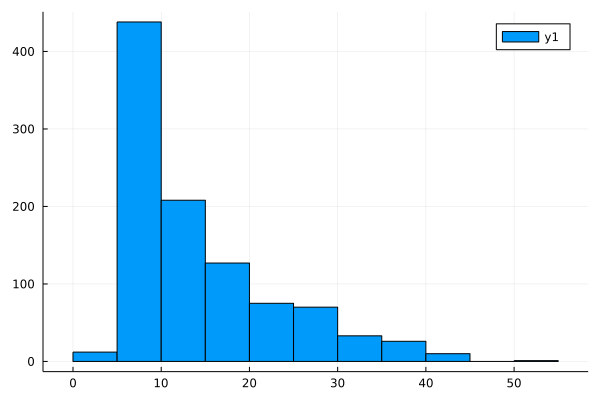

In [330]:
scatter(zs_true, m1s_true)
histogram(m1s_true)

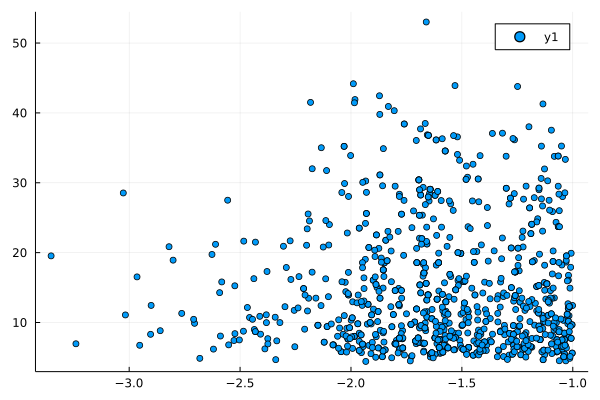

In [331]:
scatter(log10.(Zs_true), m1s_true)

In [333]:
m1_obs = Vector{Float64}()
qs_obs = Vector{Float64}()
dls_obs = Vector{Float64}()
Zs_obs = Vector{Float64}()

logwts_obs = Vector{Float64}()

Nobs = N

for i in 1:N
    m1, q, d, z, Z = m1s_true[i], qs_true[i], dls_true[i], zs_true[i], Zs_true[i]
    
    m1obstemp = zeros(0)
    qobstemp = zeros(0)
    dlobstemp = zeros(0)
    Zsobstemp = zeros(0)
    logwttemp = zeros(0)
    
    sigmam1 = sigma_m1(m1*(1+z), d)
    sigmaq = sigma_q(q, d)
    sigmadl = sigma_d(d)
    #print(i," ", sigmaq," ", q," ")
    for j in 1:Nfullsamp
    
    mo = -1.0
    sm1 = 0
    while mo < 0
        sm1 = randn!(rng, zeros(1))[1] * sigmam1
        mo = sm1 + m1*(1+z)
    end
    push!(m1obstemp, mo)
    
    qo = -1.0
    sq = 0
    while qo < 0 || qo > 1
        sq = randn!(rng, zeros(1))[1] * sigmaq
        qo = sq + q
    end
    push!(qobstemp, qo)
    
    d0 = -1.0
    sdl = 0
    while d0 < 0
        sdl = randn!(rng, zeros(1))[1] * sigmadl
        d0 = sdl + d
    end
    push!(dlobstemp,d0)
        
    push!(Zsobstemp, Z)
        

    zo = z_of_d(d0)    
    m1s = mo / (1 + zo)
    m2s = qo * m1s


    log_dN_mmz = log_dNdm1dm2dz([m1s], [m2s], [d0], [zo], [Z], alpha_true, beta_true, mmin_true, smin, smax, gamma_true, zp_true, kappa_true, dH, Om, 1-Om, w, 0.0, Z0, alphaz, sigmaz, b1, b2, b3)
    log_dN = log_dNdm1dqdd_of_dm1dm2dz(log_dN_mmz, [m1s], [d0], [zo], dH, Om, 1-Om, w, 0.0)

    log_wt = log_dN[1]
    #log_wt = logpdf(Normal(0,sigmam1),sm1) + logpdf(Normal(0,sigmaq),sq) + logpdf(Normal(0,sigmadl),sdl)
    push!(logwttemp,log_wt)
        
    end
    append!(m1_obs, m1obstemp)
    append!(qs_obs, qobstemp)
    append!(dls_obs, dlobstemp)
    append!(Zs_obs, Zsobstemp)
    append!(logwts_obs, logwttemp)

end


In [334]:
m1_obs = reshape(m1_obs, (Nfullsamp, Nobs))
qs_obs = reshape(qs_obs, (Nfullsamp, Nobs))
dls_obs = reshape(dls_obs, (Nfullsamp, Nobs))
Zs_obs = reshape(Zs_obs, (Nfullsamp, Nobs))
logwts_obs = reshape(logwts_obs, (Nfullsamp, Nobs))

print(" ")

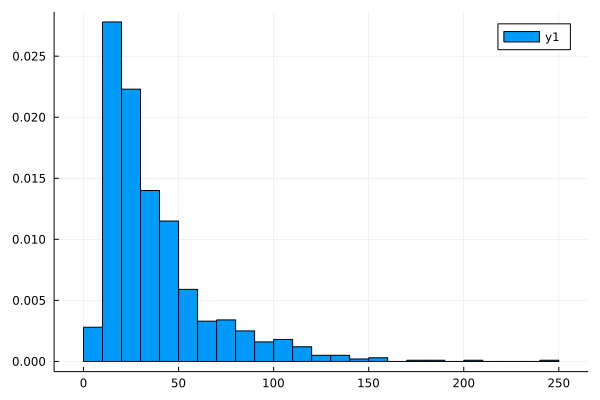

In [335]:
histogram(m1_obs[1,:], norm=true)

In [337]:
m1s_samp = Vector{Float64}()
qs_samp = Vector{Float64}()
dls_samp = Vector{Float64}()
Zs_samp = Vector{Float64}()
logwt_samp = Vector{Float64}()

for i in 1:Nobs
    m1, q, d, Z, logwt = m1_obs[:,i], qs_obs[:,i], dls_obs[:,i], Zs_obs[:,i], logwts_obs[:,i]

    wts_numer = ones(length(m1))
    wts = wts_numer
    wts /= sum(wts)
    Neff = 1.0 / sum(wts.*wts)

    if Nsamp > Neff
        @warn "Drawing more samples ($(Nsamp)) than effective samples ($(Neff))"
    end

    c = sample(collect(1:length(m1)), weights(wts), Nsamp)

    append!(m1s_samp, m1[c])
    append!(qs_samp, q[c])
    append!(dls_samp, d[c])
    append!(Zs_samp, Z[c])
    append!(logwt_samp, logwt[c]) #./sum(logwt[c]).* Nsamp)
    
    
end


In [338]:
m1s_samp = reshape(m1s_samp, (Nsamp, Nobs))
qs_samp = reshape(qs_samp, (Nsamp, Nobs))
dls_samp = reshape(dls_samp, (Nsamp, Nobs))
Zs_samp = reshape(Zs_samp, (Nsamp, Nobs))
logwt_samp = reshape(logwt_samp, (Nsamp, Nobs))

print(" ")

In [339]:
log_m1s_true = log.(m1s_true)
logit_qs_true = log.(qs_true) .- log.(1 .- qs_true)
log_dls_true = log.(dls_true)
print(" ")

In [342]:
Ndraws = 1000000
pdraws = draw_population(Ndraws, Nobs)
m1s_draw = pdraws[1]
qs_draw = pdraws[2]
zs_draw = pdraws[3]
dls_draw = pdraws[4]
Zs_draw = pdraws[5]
pts = pdraws[6]
popwts = pdraws[10]
println(Ndraws," ", length(m1s_draw)," ", pdraws[7]," ", pdraws[8])

#m1sel, qsel, dlsel, zsel, psel, Ndraw, Neff_norm = resample_selection(m1s_draw, qs_draw, zs_draw, pts, pdraws[5])
#println(Ndraw," ",Neff_norm)
m1sel, qsel, dlsel, zsel, Zsel, psel, norm, Neff_norm = m1s_draw, qs_draw, dls_draw, zs_draw, Zs_draw, pts, pdraws[7], pdraws[8]

Ndraw = length(psel)

println("Neff_norm: ", Neff_norm," norm: ",norm)


Nsel = length(m1sel)
zsel_cut = zsel[1:Nsel]
m1sel_cut = m1sel[1:Nsel]
qsel_cut = qsel[1:Nsel]
dlsel_cut = dlsel[1:Nsel]
Zsel_cut = Zsel[1:Nsel]
psel_cut = popwts[1:Nsel] ./ norm #./sum(psel[1:Nsel]) .* Nsel
logpsel_cut = log.(psel_cut)

Ndraw_cut = round(Int, Ndraw * Nsel / length(m1sel))

293640.0624078809 19.999999501382703 230.95763793672646 1000000 748.3617734951954
1000000 4000 219.7489978728016 4229.3093342775965
Neff_norm: 4229.3093342775965 norm: 219.7489978728016


4000

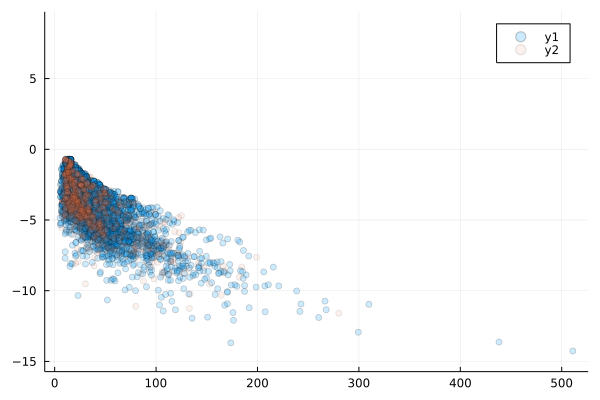

In [343]:
scatter(m1sel_cut, logpsel_cut .+ log(norm), alpha = 0.2, ylim = [-15,9])
#scatter!(m1sel_cut, log.(popwts), alpha = 0.1,  ylim = [-15,9])
scatter!(m1s_samp[1,:], logwt_samp[1,:], alpha = 0.1)

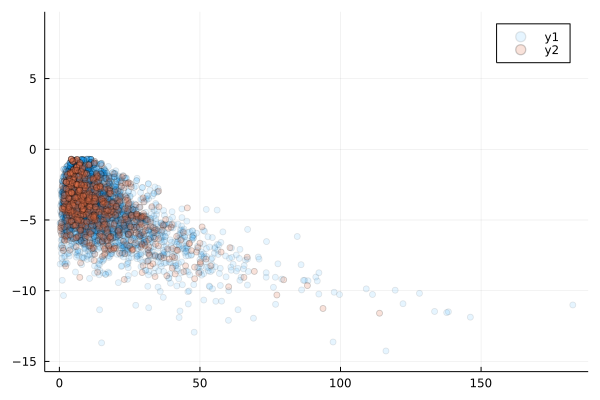

In [344]:

scatter(dlsel_cut, logpsel_cut .+ log(norm), alpha = 0.1)
scatter!(dls_samp[2,:], logwt_samp[2,:], alpha = 0.2, ylim = [-15,9])

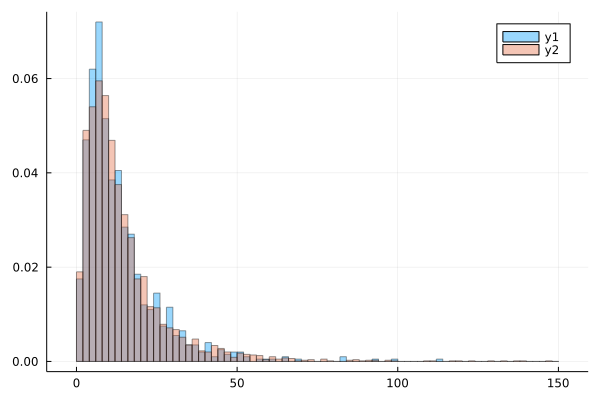

In [345]:
histogram(dls_samp[1,:], norm=true, alpha = 0.4, bins = 0:2:150)
histogram!(dlsel_cut, norm=true, alpha = 0.4, bins = 0:2:150)

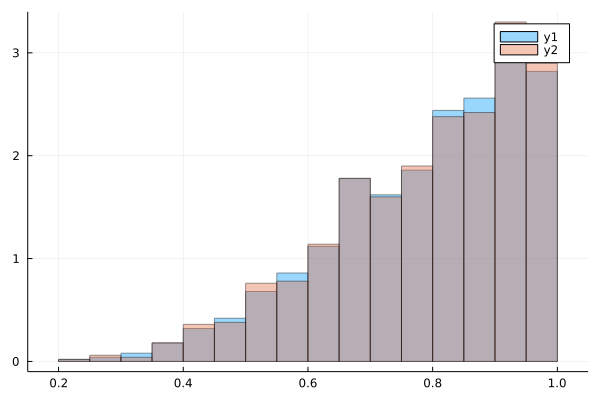

In [346]:
histogram(qs_samp[1,:], norm=true, alpha = 0.4)
histogram!(qs_samp[2,:], norm=true, alpha = 0.4)

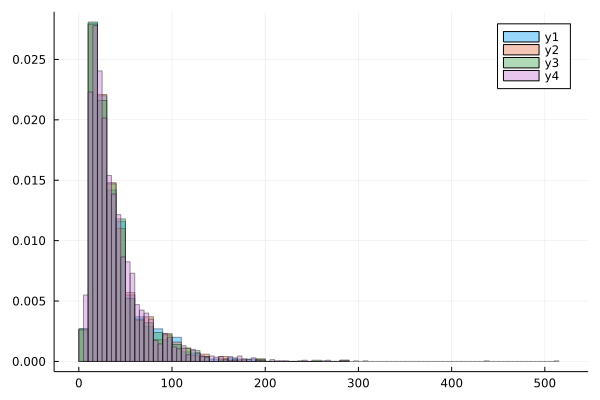

In [347]:
histogram(m1s_samp[1,:], norm=true, alpha = 0.4)
histogram!(m1s_samp[2,:], norm=true, alpha = 0.4)
histogram!(m1s_samp[3,:], norm=true, alpha = 0.4)
histogram!(m1sel_cut, norm=true, alpha = 0.4)

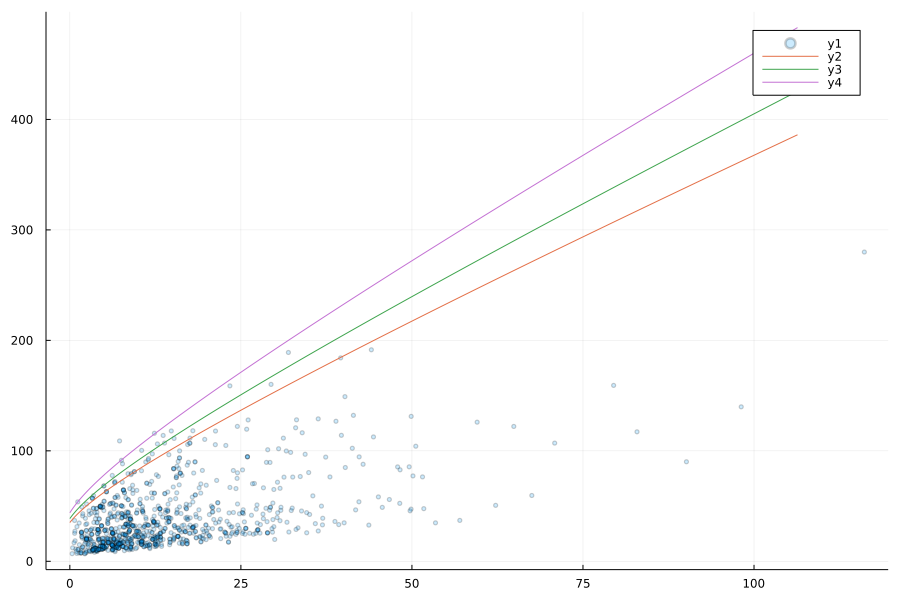

In [350]:
ztemp = expm1.(range(0, log(11), length=1024))
dtemp = [d_of_z(ztemp[i]) for i in 1:1024]

#scatter(dls_obs, m1s_obs, yerror = sigma_m1s, xerror = sigma_dls, markersize = 3, linewidth = 0.5, alpha = 0.2)
scatter(dls_true, m1s_true.*(1 .+ [z_of_d(i) for i in dls_true]), markersize = 3, linewidth = 0.5, alpha = 0.2)
plot!(dtemp, mbh_max(b1, b2, b3, 1) .* (1 .+ ztemp))
plot!(dtemp, mbh_max(b1, b2, b3, 1e-1) .* (1 .+ ztemp))
plot!(dtemp, mbh_max(b1, b2, b3, 1e-3) .* (1 .+ ztemp))


plot!(size=(900,600))

In [354]:
@model function highz_pop_simple(nobs, nsamp, nsel, ndraw, m1samp, qsamp, dlsamp, Zsamp, logwt_samp, m1sel, qsel, dlsel, Zsel, log_psel)
    
    H0 ~ truncated(Normal(67.74, 20), 10, 100) #truncated(Normal(70.0, 10.0), 0, 100)
    Om ~ truncated(Normal(0.3075, 0.2), 0.01, 0.5) # truncated(Normal(0.3, 0.1), 0, 0.5)
    #Ok ~ truncated(Normal(0, 0.1), -1, 1) # Linearly related to Ol (=1-Ok-Om) (the sampled variable), so no Jacobian 
    #w0 ~ Normal(-1.0, 0.3)
    #wm ~ Normal(0.0, 0.2)

    # mass function prior
    alpha ~ truncated(Normal(2.6, 2.0),0, 100)
    beta ~ truncated(Normal(1.3, 2.0), 0, 100)
    mmin ~ truncated(Normal(4.1, 3.0), 0.1, 15)
    mmax ~ truncated(Normal(60.0, 7.0), mmin, 100) #truncated(Normal(49.0, 15.0), mmin, 100)
    smin ~ truncated(Normal(0.15, 0.03), 0.01, 2)
    smax ~ truncated(Normal(0.17, 0.03), 0.01, 2)

    # merger rate density prior
    gamma ~ truncated(Normal(0.2, 0.2),-5, 3)
    kappa ~ truncated(Normal(3.1, 2.0), 0.1, 10)
    zp ~ truncated(Normal(1.9, 1.0), 0.001, 7)
    
    #H0 = 67.74
    #Om = 0.3075
    Ok = 0
    w0 = -1.0
    wm = 0
    dH = 299.792/H0 # Gpc
    Ol = 1 - Ok - Om
    #mpeak = 35.0
    #sigpeak = 5.7
    #fracpeak = 0.0005
    
    zinterp = expm1.(range(log(1), log(1+50), length=1024)) 
    ninterp = 1024
    dLinterp = dLs(zinterp, H0, Om, Ol, w0, wm) #[luminosity_dist(cosmosim, zinterp[i])/1000/ u"Mpc" for i in 1:ninterp]
    
    # neff
    for i in 2:ninterp
      if dLinterp[i] < dLinterp[i-1] 
        print("closed universe contracting at z = " + string(zinterp[i]))
        Turing.@addlogprob! -Inf
      end
    end
    
    z_of_d = LinearInterpolation(dLinterp, zinterp)
    d_of_z = LinearInterpolation(zinterp, dLinterp)
    
    if maximum(dlsel) > maximum(dLinterp) || minimum(dlsel) < minimum(dLinterp)
        Turing.@addlogprob! -Inf
    else
        
    zsel = [z_of_d(dlsel[i]) for i in 1:nsel]

    m1ssel = m1sel ./ (1 .+ zsel)
    m2ssel = qsel .* m1ssel

    log_dN_mmz_sel = log_dNdm1dm2dz(m1ssel, m2ssel, dlsel, zsel, Zsel, alpha, beta, mmin, smin, smax, gamma, zp, kappa, dH, Om, Ol, w0, wm, Z0, alphaz, sigmaz, b1, b2, b3)
    log_dN_sel = log_dNdm1dqdd_of_dm1dm2dz(log_dN_mmz_sel, m1ssel, dlsel, zsel, dH, Om, Ol, w0, wm)

    log_wt_sel = log_dN_sel .- log_psel
    log_wt2_sel = 2.0 .* log_wt_sel

    log_mu_sel = logsumexp(log_wt_sel) - log(ndraw)
    log_s2_sel = logsubexp(logsumexp(log_wt2_sel) - 2.0*log(ndraw), 2.0*log_mu_sel - log(ndraw))

    neff = exp(2.0*log_mu_sel - log_s2_sel)

    # if (neff < 4*nobs) 
    #     #@warn "not enough samples to estimate selection integral " + string(neff) + " " + string(nobs)
    #     Turing.@addlogprob! -Inf
    #     println("neff not enough", " ", neff, " ", nobs, " ", H0, " ", Om, " ", alpha, " ", beta, " ", mmin, " ", mmax, " ", smin, " ", smax, " ", gamma, " ", kappa, " ", zp)
    # end
    
    #neff ends
    
    for i in 1:nobs

      dls = dlsamp[:,i]
      Zs = Zsamp[:,i]

      if maximum(dls) > maximum(dLinterp) || minimum(dls) < minimum(dLinterp)
            Turing.@addlogprob! -Inf
      else


      zs = [z_of_d(dls[j]) for j in 1:nsamp]
      m1s = m1samp[:,i]./(1 .+ zs)
      m2s = m1s .* qsamp[:,i]

      log_dN_mmz = log_dNdm1dm2dz(m1s, m2s, dls, zs, Zs, alpha, beta, mmin, smin, smax, gamma, zp, kappa, dH, Om, Ol, w0, wm, Z0, alphaz, sigmaz, b1, b2, b3)
      log_dN_mdl = log_dNdm1dqdd_of_dm1dm2dz(log_dN_mmz, m1s, dls, zs, dH, Om, Ol, w0, wm)

      log_dN_sum = logsumexp(log_dN_mdl)# - logwt_samp[:,i])
      Turing.@addlogprob! (log_dN_sum - log(nsamp))
      end

    end

    Turing.@addlogprob! (-nobs*(log_mu_sel))# - nobs/(2*neff)))
    end
                        
end

highz_pop_simple (generic function with 2 methods)

In [355]:
θ0 = [67.74, 0.3075, 4.8, 2.1, 7.1, 49.0, 0.17, 0.15, 0.2, 3.1, 1.9]
# Sampler params
δ = 0.65 # Acceptance ratio
max_depth = 7 # Tree depth
init_ϵ = 0.2
Niter = 400
model = highz_pop_simple(Nobs, Nsamp, Nsel, Ndraw, m1s_samp, qs_samp, dls_samp, Zs_samp, logwt_samp, m1sel_cut, qsel_cut, dlsel_cut, Zsel_cut, logpsel_cut)
#model = highz_pop_simple_pl(Nobs, Nsamp, Nsel, Ndraw, m1s_samp, qs_samp, dls_samp, logwt_samp, m1sel_cut, qsel_cut, dlsel_cut, logpsel_cut)
Nthread = 1

1

In [356]:
Turing.setchunksize(length(θ0))
sampler = Turing.NUTS(Niter, δ; metricT = AdvancedHMC.DenseEuclideanMetric, max_depth=max_depth, init_ϵ=init_ϵ)
if Nthread > 1
    trace = sample(model, sampler, MCMCThreads(), Niter, Nthread, init_theta = θ0, progress=true)
else
    trace = sample(model, sampler, Niter, init_theta = θ0, progress=true)
end

┌ Info: [Turing]: AD chunk size is set as 11
└ @ Turing.Core /Users/cosmonana/.julia/packages/Turing/y0DW3/src/core/ad.jl:33
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /Users/cosmonana/.julia/packages/AdvancedHMC/yd6UP/src/hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /Users/cosmonana/.julia/packages/AdvancedHMC/yd6UP/src/hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /Users/cosmonana/.julia/packages/AdvancedHMC/yd6UP/src/hamiltonian.jl:47
Sampling:   3%|█▎                                       |  ETA: 0:13:14┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, 

Chains MCMC chain (400×23×1 Array{Float64, 3}):

Iterations        = 401:1:800
Number of chains  = 1
Samples per chain = 400
Wall duration     = 2878.53 seconds
Compute duration  = 2878.53 seconds
parameters        = alpha, gamma, kappa, Om, mmin, H0, smin, mmax, beta, smax, zp
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size

Summary Statistics
  parameters      mean       std   naive_se      mcse        ess      rhat   e ⋯
      Symbol   Float64   Float64    Float64   Float64    Float64   Float64     ⋯

          H0   67.6527    4.3444     0.2172    0.2026   113.2342    1.0038     ⋯
          Om    0.3547    0.0715     0.0036    0.0031    98.7959    1.0030     ⋯
       alpha    4.7255    0.1379     0.0069    0.0061   366.9023    0.9986     ⋯
        beta    1.8530    0.1397     0.0070    0.0051   354.9768    0.9975     ⋯
        mm

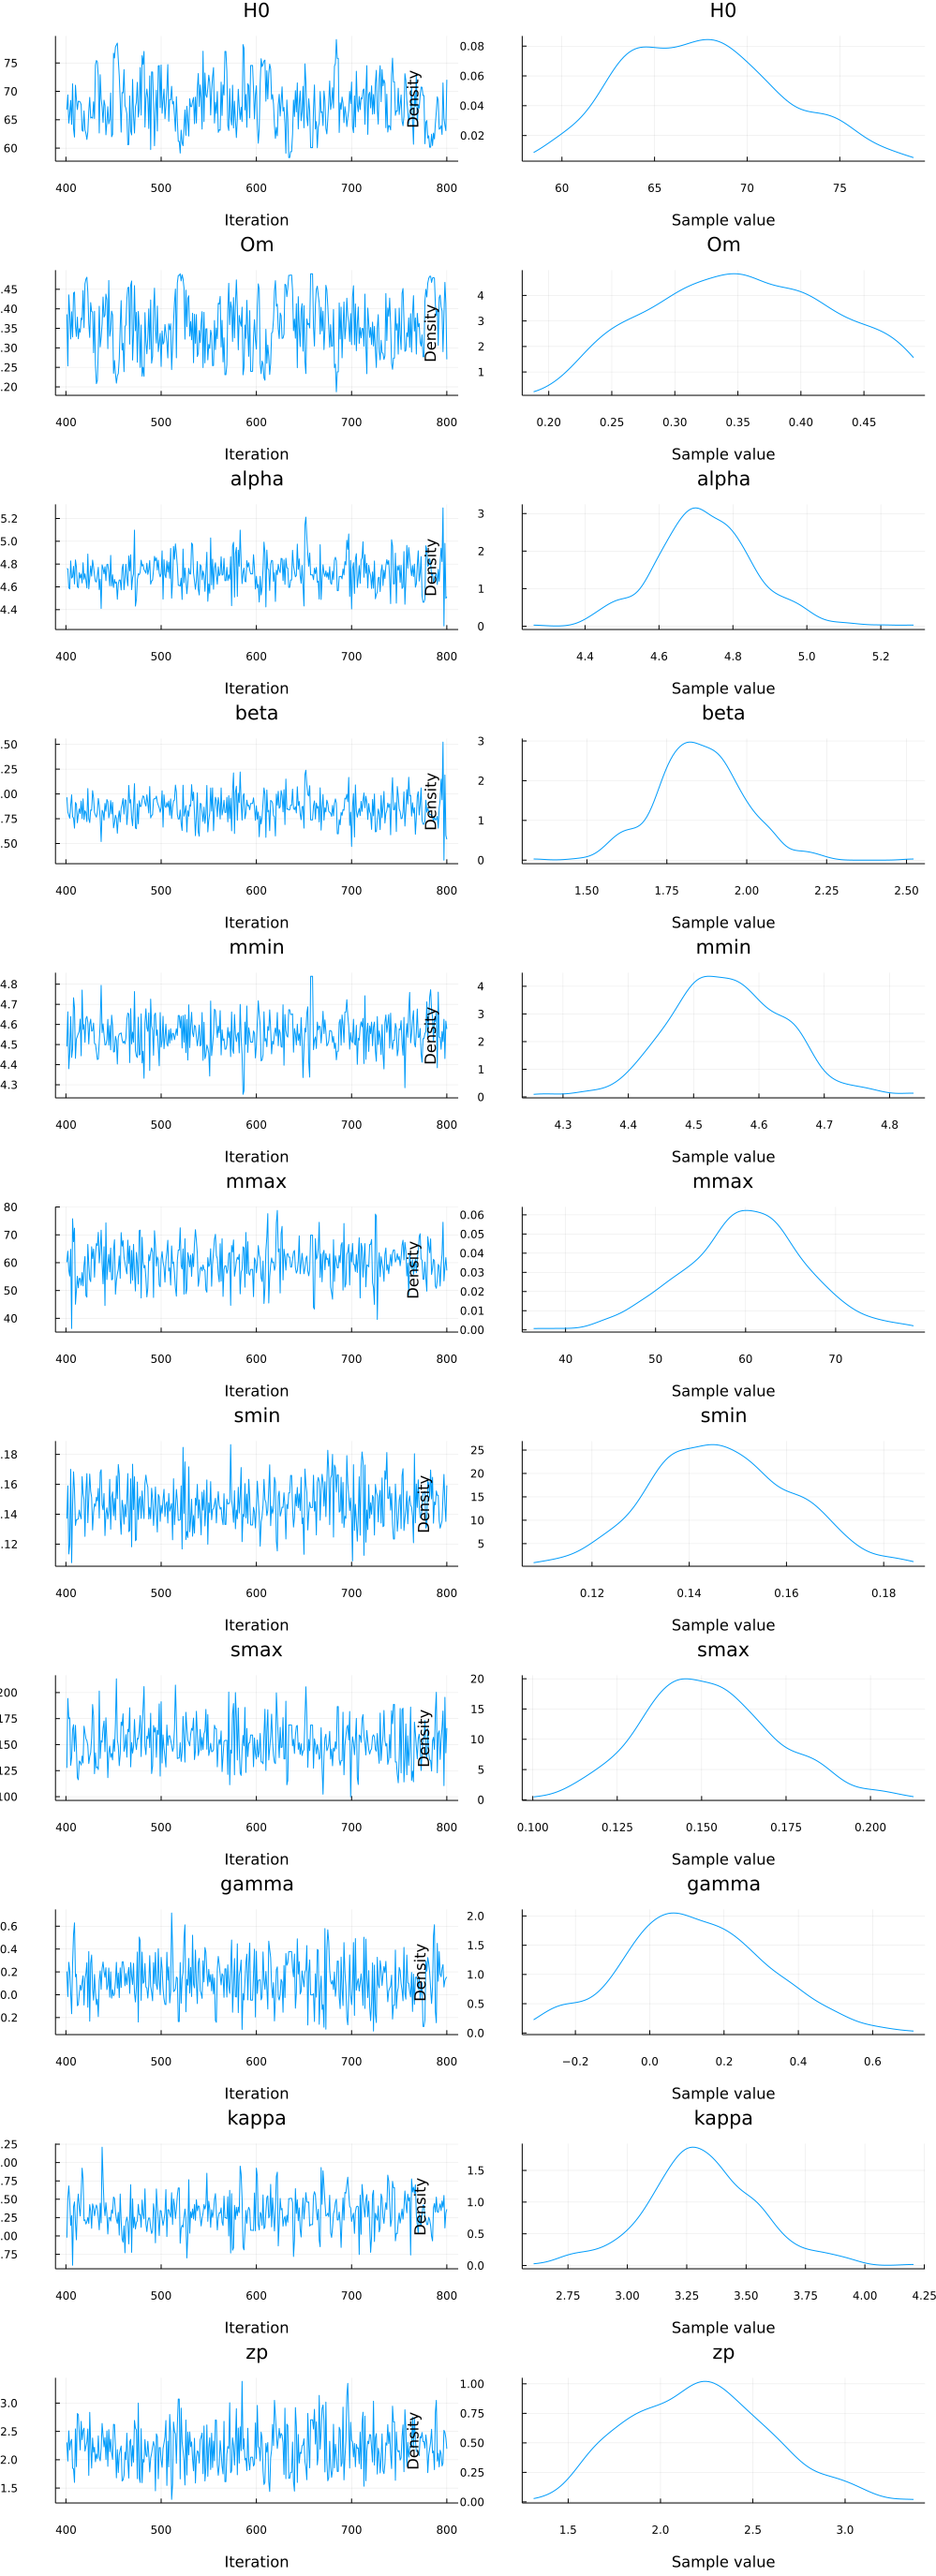

In [359]:
plot(trace)

In [358]:
write("chains/chains_highz_pop_mpeak_obs_1000_ndraw4000_step400_trace_metal_nulltest.jls", trace)

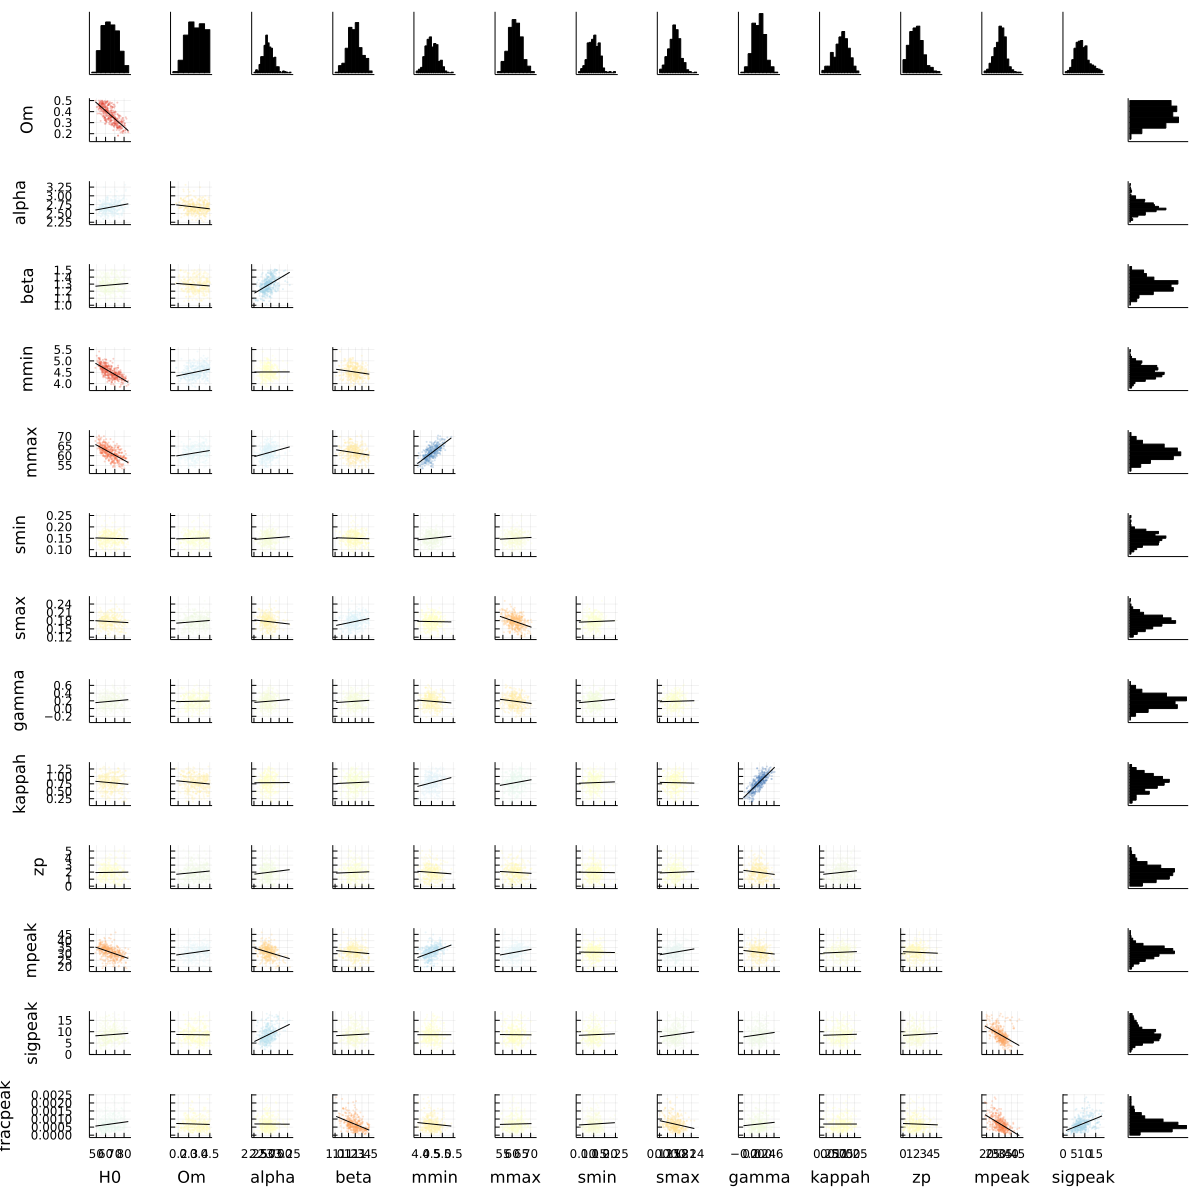

In [99]:
Turing.corner(trace)
plot!(size=(1200,1200))

In [148]:
trace

Chains MCMC chain (1600×28×1 Array{Float64, 3}):

Iterations        = 1601:1:3200
Number of chains  = 1
Samples per chain = 1600
Wall duration     = 12925.36 seconds
Compute duration  = 12925.36 seconds
parameters        = alpha, gamma, wm, mpeak, fracpeak, w0, sigpeak, kappa, Om, mmin, H0, smin, mmax, beta, smax, zp
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size

Summary Statistics
  parameters      mean       std   naive_se      mcse         ess      rhat    ⋯
      Symbol   Float64   Float64    Float64   Float64     Float64   Float64    ⋯

          H0   65.5704    9.8073     0.2452    0.4018    734.3578    1.0052    ⋯
          Om    0.2891    0.0839     0.0021    0.0046    529.2375    1.0017    ⋯
          w0   -1.0693    0.2800     0.0070    0.0077   1366.7934    1.0036    ⋯
          wm    0.0448    0.1131     0.0028    0.00